## Worflow
- Set network parameters
- Optimize for twiddle bits
- Collect training and validation data
- Train for wiggly function
- Validate training

Fixed parameters:
- number of neurons

Swept parameters:
- function wiggliness
- fmax

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
from nengo_brainstorm.solvers import CVXSolver
from nengo_extras.plot_spikes import plot_spikes

import pystorm
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.run_control import RunControl
from pystorm.hal.calibrator import Calibrator, PoolSpec
from pystorm.hal.data_utils import lpf, bin_to_spk_times, bins_to_rates

import utils

In [2]:
# swept parameters

# X = 16
# Y = 16
# # FMAX_OUTS = [500]
# FMAX_OUTS = [1500, 1000, 500]

X = 32
Y = 32
FMAX_OUTS = [1500, 1000, 500]
# FMAX_OUTS = [2000, 1500, 1000]

# X = 64
# Y = 64
# FMAX_OUTS = [500]
# FMAX_OUTS = [4000, 1000]

# REG_L1_L2 = [0.1, 0.001, 0.00001, 1e-7, 1e-9]
REG_L1_L2 = [0.001,]

FCN_F = [1, 2, 4]
# FCN_F = [2.0]

# fixed parameters
# network parameters
NNEURON = X*Y
DIM = 1

DATA_DIR = "data/test_accumulator_decodes/"
FIG_DIR = "figures/test_accumulator_decodes/"

# experimental parameters
TRAINING_DOWNSTREAM_NS = 10000 # minimum time resolution, downstream time resolution
TRAINING_UPSTREAM_NS   = 1000000 # default upstream time resolution
FMAX_IN = 2000
TUNING_INPUT_POINTS = 240 # number of input points to take for collecting tuning data
TUNING_POINT_TIME_NS = int(0.5*1E9) # time to record data per tuning curve input point
VALIDATION_SKIP = 7 # reserve every VALIDATION_SKIP points from tuning data for validation
TEST_INPUT_POINTS = 121 # number of input points to take for validating fit
TEST_POINT_TIME_NS = int(0.5*1E9) # time to collect data for each testing point
TESTING_DOWNSTREAM_NS = 10000 # downstream time resolution for testing
TESTING_UPSTREAM_NS = 100000 # upstream time resolution for testing
TESTING_RAW_SPIKES_DOWNSTREAM_NS = 1000 # downstream time resolution for collecting raw spikes for testing
TESTING_RAW_SPIKES_UPSTREAM_NS = 10000 # downstream time resolution for collecting raw spikes for testing
CLIP_TIME = 0.5 # how much of the initial data to discard during testing
TAU_READOUT = 0.1 # synaptic readout time constant
FSCALE = 1000.

In [3]:
PS_ORIG = PoolSpec(
    label = "pool",
    YX = (Y, X),
    loc_yx = (0, 0),
    D = DIM,
)

def FCN(x, f):
    """Base function used in testing"""
    return 0.5 + 0.5*np.sin(np.pi*f*x)

class ExpData:
    def __init__(self, fmax_in, fmax_outs, fcn_fs):
        self.fmax_in = fmax_in
        self.fmax_outs = fmax_outs
        self.fcn_fs = fcn_fs

In [4]:
def get_nrmse(fit, target, normal_factor):
    assert fit.shape == target.shape
    return np.sqrt(np.mean((fit - target)**2))/normal_factor

In [5]:
def sweep_inputs_collect_spikes(
        net, hal, run_control,
        input_points, fmax_in, time_per_point_ns, fname_pre_cache, fname_post_cache=""):
    """Collect tuning data to be used when fitting decoders"""
    n_pts = len(input_points)
    time_points_ns = np.arange(n_pts+1)*time_per_point_ns
    input_rates = np.zeros((n_pts+1, 1))
    input_rates[:n_pts, 0] = fmax_in*input_points
    input_rates[-1, 0] = input_rates[-2, 0]
    input_data = {net.input:(time_points_ns, input_rates)}

    fname_cache = (
        DATA_DIR + fname_pre_cache + "_" + str(PS_ORIG.YX) + "_" +
        str(PS_ORIG.loc_yx) + "_" + str(n_pts) + "_" + str(time_per_point_ns) + fname_post_cache + ".pck")
    def sweep_fun():
        _, spike_data = run_control.run_input_sweep(
            input_data, get_raw_spikes=True, get_outputs=False)
        spikes, bin_times_ns = spike_data
        spikes = spikes[net.pool]    
        spike_rates = bins_to_rates(spikes, bin_times_ns,
                                    time_points_ns, init_discard_frac=0.5)
        return spike_rates
    spike_rates = utils.cache_fun(fname_cache, sweep_fun)
    return input_rates[:-1], spike_rates

def sweep_inputs_collect_decodes(
        net, hal, run_control,
        input_points, fmax_in, time_per_point_ns, fname_pre_cache, fname_post_cache="", decoders=None):
    """Collect decode data to test decoders"""
    time_points_ns = np.arange(input_points+1)*time_per_point_ns
    input_rates = np.zeros((input_points+1, 1))
    input_rates[:input_points, 0] = fmax_in * np.linspace(-1, 1, input_points)
    input_rates[-1, 0] = input_rates[-2, 0]
    input_data = {net.input:(time_points_ns, input_rates)}

    fname_cache = (
        DATA_DIR + fname_pre_cache + "_" + str(PS_ORIG.YX) + "_" +
        str(PS_ORIG.loc_yx) + "_" + str(input_points) + "_" + str(time_per_point_ns) + fname_post_cache + ".pck")
    def sweep_fun():
        if decoders is not None:
            net.decoder_conn.reassign_weights(decoders)
            hal.remap_weights()
        output_data, _ = run_control.run_input_sweep(
            input_data, get_raw_spikes=False, get_outputs=True)
        outputs, bin_times_ns = output_data
        outputs = outputs[net.output][:, 0].reshape((-1, 1))
        output_rates = bins_to_rates(outputs, bin_times_ns,
                                     time_points_ns, init_discard_frac=0.5)
        return output_rates
    output_rates = utils.cache_fun(fname_cache, sweep_fun)
    return input_rates[:-1], output_rates

In [6]:
def collect_tuning_data(exp_data, net, hal, run_control,
                        n_input_points, time_per_point_ns, valid_skip):
    """Collect tuning data from the chip to be used when fitting decoders"""
    hal.set_time_resolution(TRAINING_DOWNSTREAM_NS, TRAINING_UPSTREAM_NS)
    N_PERIODS = 5
    tuning_input_points = np.zeros(n_input_points)
    period_length = n_input_points//N_PERIODS
    input_base = np.linspace(-1, 1, period_length)
    input_rep = np.zeros(period_length)
    input_rep[:period_length//2] = input_base[::2]
    input_rep[period_length//2:] = input_base[1::2][::-1]
    tuning_input_points = np.tile(input_rep, N_PERIODS)

    start_idx = valid_skip//2
    t_idx = np.ones(n_input_points, dtype=bool)
    t_idx[start_idx::valid_skip] = False
    v_idx = ~t_idx
    training_input_points = tuning_input_points[t_idx]
    validation_input_points = tuning_input_points[v_idx]
    
    exp_data.training_input_rates, exp_data.training_spike_rates = sweep_inputs_collect_spikes(
        net, hal, run_control, training_input_points, exp_data.fmax_in, time_per_point_ns, "training",
        fname_post_cache= "_" + str(FMAX_IN))
    
    exp_data.validation_input_rates, exp_data.validation_spike_rates = sweep_inputs_collect_spikes(
        net, hal, run_control, validation_input_points, exp_data.fmax_in, time_per_point_ns, "validation",
        fname_post_cache= "_" + str(FMAX_IN))

def generate_tuning_data(exp_data, n_pts, cal, opt_encs, opt_offsets, opt_ps_out, valid_skip):
    """generate data from estimated encoders and decoders"""
    tuning_input_points = np.linspace(-1, 1, n_pts).reshape((n_pts, 1))
    start_idx = valid_skip//2
    t_idx = np.ones(n_pts, dtype=bool)
    t_idx[start_idx::valid_skip] = False
    v_idx = ~t_idx
    training_input_points = tuning_input_points[t_idx]
    validation_input_points = tuning_input_points[v_idx]
    
    x_pts = np.linspace(-1, 1, n_pts).reshape((n_pts, 1))
    est_A = np.maximum(0, np.dot(x_pts, opt_encs.T) + opt_offsets)
    
    exp_data.training_input_rates = training_input_points * exp_data.fmax_in
    exp_data.training_spike_rates = np.maximum(0, np.dot(training_input_points, opt_encs.T) + opt_offsets)
    exp_data.validation_input_rates = validation_input_points * exp_data.fmax_in
    exp_data.validation_spike_rates = np.maximum(0, np.dot(validation_input_points, opt_encs.T) + opt_offsets)
    
    # validate generated data against a small sample of collected data
    N_val_samples = 20
    val_pts = np.linspace(-1, 1, N_val_samples).reshape((N_val_samples, 1))
    val_rmse, val_meas_A, val_est_A = cal.validate_est_encs(opt_encs, opt_offsets, opt_ps_out, val_pts)

    diff = np.abs(val_est_A - val_meas_A)
    diff[np.isnan(diff)] = 0

    plt.figure()
    valid_means = np.sqrt(np.mean(diff**2, axis=0))
    plt.hist(valid_means)

    mean_rmse = np.mean(valid_means)
    print(mean_rmse)

    thr = 4
    big_err = valid_means > thr * mean_rmse
    plt.axvline(thr * mean_rmse)

    print(np.sum(big_err))
    
    # zero out tuning data that's inconsistent with collected data
    exp_data.training_spike_rates[:, big_err] = 0
    exp_data.validation_spike_rates[:, big_err] = 0
    # zero out nan values in tuning data (from encoders that weren't estimated)
    nan_idx = np.isnan(exp_data.training_spike_rates)
    exp_data.training_spike_rates[nan_idx] = 0
    nan_idx = np.isnan(exp_data.validation_spike_rates)
    exp_data.validation_spike_rates[nan_idx] = 0

def load_tuning_data(exp_data, fnames, valid_skip):
    """Load tuning data from a set of files"""
    if isinstance(fnames, str):
        fnames = [fnames]
    datasets = []
    for fname in fnames:
        with open(fname, 'rb') as fhandle:
            datasets += [pickle.load(fhandle)]
    input_rates = np.array([dataset.input_rates for dataset in datasets]).flatten().reshape((-1, 1))
    spike_rates = np.vstack(np.array([dataset.spike_rates for dataset in datasets]))
    n_input_points = len(input_rates)
    start_idx = valid_skip//2
    t_idx = np.ones(n_input_points, dtype=bool)
    t_idx[start_idx::valid_skip] = False
    v_idx = ~t_idx
    
    sort_idx = np.argsort(input_rates, axis=0).flatten()
    input_rates = input_rates[sort_idx]
    spike_rates = spike_rates[sort_idx]
    
    exp_data.training_input_rates = input_rates[t_idx]
    exp_data.training_spike_rates = spike_rates[t_idx]
    exp_data.validation_input_rates = input_rates[v_idx]
    exp_data.validation_spike_rates = spike_rates[v_idx]
    
def plot_tuning(exp_data, array_width, array_height):
    t_inputs = exp_data.training_input_rates
    t_spike_rates = exp_data.training_spike_rates
    v_inputs = exp_data.validation_input_rates
    v_spike_rates = exp_data.validation_spike_rates

    fig, (ax_t, ax_v) = plt.subplots(ncols=2, figsize=(14, 4), sharex=True)

    half_width = array_width//2
    t_lines = ax_t.plot(t_inputs, t_spike_rates)
    v_lines = ax_v.plot(v_inputs, v_spike_rates)
    for idx in range(array_height):
        start_l = idx*array_width
        start_r = start_l + half_width
        for idx in range(start_l, start_l+half_width):
            t_lines[idx].set_color('r')
            v_lines[idx].set_color('r')
        for idx in range(start_r, start_r+half_width):
            t_lines[idx].set_color('b')
            v_lines[idx].set_color('b')  
    ax_t.set_title("Training tuning data")
    ax_v.set_title("Validation tuning data")
    fig.savefig(FIG_DIR + "tuning" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
                "_fmax_in_" + str(exp_data.fmax_in) + "_"  +
                str(TUNING_INPUT_POINTS) + "_" + str(TUNING_POINT_TIME_NS) + ".png")

def plot_tuning_subset(exp_data, n_sample):
    t_inputs = exp_data.training_input_rates
    t_spike_rates = exp_data.training_spike_rates
    v_inputs = exp_data.validation_input_rates
    v_spike_rates = exp_data.validation_spike_rates

    idx = np.random.choice(np.arange(X*Y), n_sample, replace=False)
    fig, (ax_t, ax_v) = plt.subplots(ncols=2, figsize=(14, 4), sharex=True)

    t_lines = ax_t.plot(t_inputs, t_spike_rates[:, idx])
    v_lines = ax_v.plot(v_inputs, v_spike_rates[:, idx])
    ax_t.set_title("Training tuning data")
    ax_v.set_title("Validation tuning data")

In [7]:
EXP_DATA = ExpData(FMAX_IN, FMAX_OUTS, FCN_F)
HAL = pystorm.hal.HAL()
NET_BUILDER = NetBuilder(HAL)
CALIBRATOR = Calibrator(HAL)

checking cache for data/test_accumulator_decodes/pool_(32, 32)_(0, 0).pck
found cache


/Users/samfok/Code/pystorm/pystorm/hal/calibrator.py:794: RuntimeWarning: invalid value encountered in less
  good_mask = (intercepts < 1) & (intercepts > -1)
/Users/samfok/Code/pystorm/pystorm/hal/calibrator.py:794: RuntimeWarning: invalid value encountered in greater
  good_mask = (intercepts < 1) & (intercepts > -1)


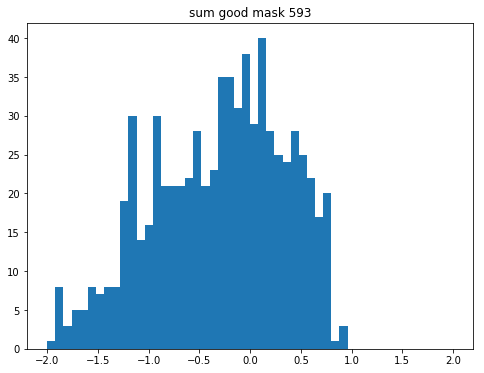

In [8]:
def build_net(ps_orig, net_builder, calibrator, exp_data):
    d_matrix = np.zeros((2, Y*X))    
    p_fname = (DATA_DIR + ps_orig.label + "_" + str(ps_orig.YX) + "_" + str(ps_orig.loc_yx) + ".pck")
    ps_opt, est_enc, est_off = utils.optimize_yield_w_cache(ps_orig, p_fname, calibrator)
    exp_data.ps = ps_opt
    intercepts, good_mask = calibrator.get_intercepts(est_enc, est_off)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title("sum good mask {}".format(np.sum(good_mask)))
    ax.hist(intercepts[~np.isnan(intercepts)], bins=50, range=(-2, 2))
    fig.savefig(FIG_DIR + "intercepts" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
                "_"  + str(TUNING_INPUT_POINTS) + "_" + str(TUNING_POINT_TIME_NS) + ".png")
    net = net_builder.create_single_pool_net_from_spec(exp_data.ps, d_matrix)
    return net, ps_opt, est_enc, est_off

NET, PS_OPT, ENC_OPT, OFF_OPT = build_net(PS_ORIG, NET_BUILDER, CALIBRATOR, EXP_DATA)
RUN_CONTROL = RunControl(HAL, NET)
HAL.map(NET)

# Collect Tuning Data

- Check that tuning curves look reasonable

In [9]:
# collect_tuning_data(EXP_DATA, NET, HAL, RUN_CONTROL, TUNING_INPUT_POINTS, TUNING_POINT_TIME_NS, VALIDATION_SKIP)

# generate_tuning_data(EXP_DATA, TUNING_INPUT_POINTS, CALIBRATOR, ENC_OPT, OFF_OPT, PS_OPT, VALIDATION_SKIP)

class TuningData:
    def __init__(self, input_rates, spike_rates):
        self.input_rates = input_rates
        self.spike_rates = spike_rates
DATA_TUNING_DIR = "data/test_accumulator_decodes/tuning/"
DATA_FNAME_BASE = (DATA_TUNING_DIR + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
                   "_fmax_in_" + str(FMAX_IN) + "_samples_1200_sample_time_500ms_discard_0.5")
DATA_FNAMES = [
    DATA_FNAME_BASE + "_set_2.pck",
    DATA_FNAME_BASE + "_set_3.pck",
]
load_tuning_data(EXP_DATA, DATA_FNAMES, VALIDATION_SKIP)

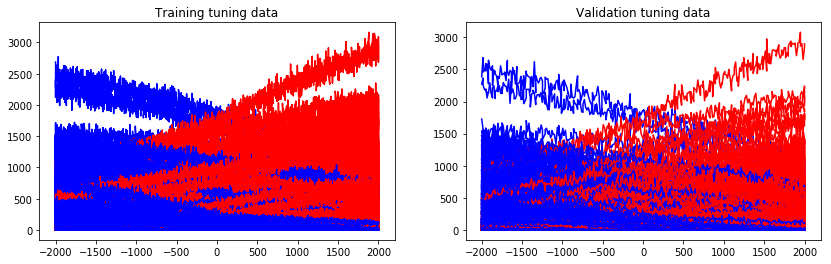

In [10]:
plot_tuning(EXP_DATA, X, Y)

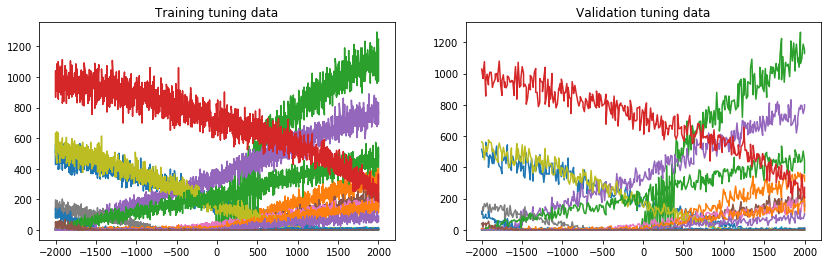

In [11]:
plot_tuning_subset(EXP_DATA, 16) # look at a smaller subset of the data

# Train, Validate, Test Decoders

Solving for fmax_out 1500 fcn_f 1.0
checking cache for data/test_accumulator_decodes/decoders_(32, 32)_(0, 0)_fmax_out_1500_fcn_f_1_L1L2_0.001.pck
found cache
	reg 1.0e-03 v_nrmse 0.025481
Solving for fmax_out 1500 fcn_f 2.0
checking cache for data/test_accumulator_decodes/decoders_(32, 32)_(0, 0)_fmax_out_1500_fcn_f_2_L1L2_0.001.pck
found cache
	reg 1.0e-03 v_nrmse 0.077225
Solving for fmax_out 1500 fcn_f 4.0
checking cache for data/test_accumulator_decodes/decoders_(32, 32)_(0, 0)_fmax_out_1500_fcn_f_4_L1L2_0.001.pck
found cache
	reg 1.0e-03 v_nrmse 0.253920
Solving for fmax_out 1000 fcn_f 1.0
checking cache for data/test_accumulator_decodes/decoders_(32, 32)_(0, 0)_fmax_out_1000_fcn_f_1_L1L2_0.001.pck
found cache
	reg 1.0e-03 v_nrmse 0.025335
Solving for fmax_out 1000 fcn_f 2.0
checking cache for data/test_accumulator_decodes/decoders_(32, 32)_(0, 0)_fmax_out_1000_fcn_f_2_L1L2_0.001.pck
found cache
	reg 1.0e-03 v_nrmse 0.076275
Solving for fmax_out 1000 fcn_f 4.0
checking cache for 

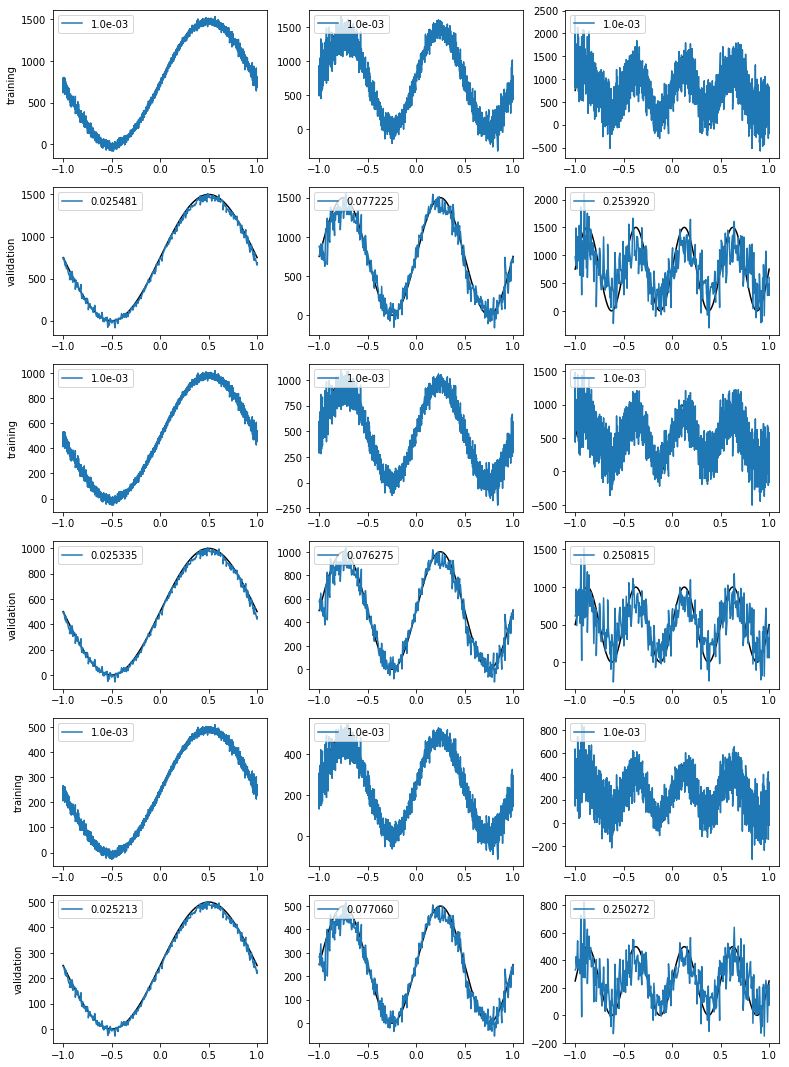

In [12]:
def fit_decoders(rates, target_function, reg_l1, reg_l2):
    solver = CVXSolver(reg=reg_l2, reg_l1=reg_l1)
    decoders, info = solver(rates/FSCALE, target_function/FSCALE)
    decoders = decoders.clip(-1, 1)
    return decoders, info

def run_fits(exp_data):
    exp_data.decoders = []
    exp_data.training_targets = []
    exp_data.reg = np.zeros((len(exp_data.fmax_outs), len(exp_data.fcn_fs)))
    v_input = exp_data.validation_input_rates/exp_data.fmax_in
    v_spike_rates = exp_data.validation_spike_rates

    t_input = exp_data.training_input_rates/exp_data.fmax_in
    t_spike_rates = exp_data.training_spike_rates
    
    nrows = 2*len(exp_data.fmax_outs)
    ncols = len(exp_data.fcn_fs)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4+1, nrows*3+1))
    if ncols == 1:
        axs = np.array([axs]).T
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.training_targets += [[]]
        exp_data.decoders += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            t_target = fmax_out * FCN(
                t_input, fcn_f) 
            print("Solving for fmax_out {:.0f} fcn_f {:.1f}".format(fmax_out, fcn_f))
            v_nrmse = np.zeros(len(REG_L1_L2))
            v_target = fmax_out * FCN(v_input, fcn_f)
            decoders_sweep = []
            axs[2*idx0+0][idx1].plot(t_input, t_target, 'k')
            axs[2*idx0+1][idx1].plot(v_input, v_target, 'k')
            for idx, reg in enumerate(REG_L1_L2):
                fname_cache = (
                    DATA_DIR + "decoders_" +
                    str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
                    "_fmax_out_" + str(fmax_out) + "_fcn_f_" + str(fcn_f) +
                    "_L1L2_" + str(reg) + ".pck")
                def cached_fit_decoders():
                    decoders, info = fit_decoders(
                        t_spike_rates, t_target, reg, reg)
                    return decoders, info
                decoders, info = utils.cache_fun(fname_cache, cached_fit_decoders)
                t_fit = np.dot(t_spike_rates, decoders)
                v_fit = np.dot(v_spike_rates, decoders)
                v_nrmse[idx] = get_nrmse(v_fit, v_target, fmax_out)
                print("\treg {:.1e} v_nrmse {:.6f}".format(reg, v_nrmse[idx]))
                axs[2*idx0+0][idx1].plot(t_input, t_fit, label="{:.1e}".format(reg))
                axs[2*idx0+1][idx1].plot(v_input, v_fit, label="{:.6f}".format(v_nrmse[idx]))
                decoders_sweep.append(decoders)
            reg_idx = np.argmin(v_nrmse)
            exp_data.reg[idx0, idx1] = REG_L1_L2[reg_idx]
            exp_data.decoders[-1] += [decoders_sweep[reg_idx]]
            exp_data.training_targets[-1] += [t_target]
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        axs[2*idx0+0][0].set_ylabel("training")
        axs[2*idx0+1][0].set_ylabel("validation")
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            axs[2*idx0+0][idx1].legend(loc="upper left")
            axs[2*idx0+1][idx1].legend(loc="upper left")
    exp_data.training_input = t_input

run_fits(EXP_DATA)

In [13]:
def test_decoders(exp_data, hal, net, run_control):
    exp_data.test_input_rates = None
    exp_data.test_output_rates = []
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.test_output_rates += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            print("testing decoders optimized for fcn_f {:.1f} and fmax_out {:d}".format(fcn_f, fmax_out))
            dweights = np.zeros((2, Y*X))
            decoders = exp_data.decoders[idx0][idx1].flatten()
            dweights[0] = decoders
            test_input_rates, test_output_rates = sweep_inputs_collect_decodes(
                net, hal, run_control, TEST_INPUT_POINTS,
                exp_data.fmax_in, TEST_POINT_TIME_NS, "testing",
                decoders=dweights,
                fname_post_cache="_fmax_in_{:d}_fcn_f_{:.1f}_fmax_out_{:d}_L1_{:f}_L2_{:f}".format(
                    exp_data.fmax_in, fcn_f, fmax_out, exp_data.reg[idx0, idx1], exp_data.reg[idx0, idx1],))
            if idx0 == 0 and idx1 == 0:
                exp_data.test_input_rates = test_input_rates
            exp_data.test_output_rates[idx0] += [test_output_rates]
test_decoders(EXP_DATA, HAL, NET, RUN_CONTROL)

testing decoders optimized for fcn_f 1.0 and fmax_out 1500
checking cache for data/test_accumulator_decodes/testing_(32, 32)_(0, 0)_121_500000000_fmax_in_2000_fcn_f_1.0_fmax_out_1500_L1_0.001000_L2_0.001000.pck
found cache
testing decoders optimized for fcn_f 2.0 and fmax_out 1500
checking cache for data/test_accumulator_decodes/testing_(32, 32)_(0, 0)_121_500000000_fmax_in_2000_fcn_f_2.0_fmax_out_1500_L1_0.001000_L2_0.001000.pck
found cache
testing decoders optimized for fcn_f 4.0 and fmax_out 1500
checking cache for data/test_accumulator_decodes/testing_(32, 32)_(0, 0)_121_500000000_fmax_in_2000_fcn_f_4.0_fmax_out_1500_L1_0.001000_L2_0.001000.pck
found cache
testing decoders optimized for fcn_f 1.0 and fmax_out 1000
checking cache for data/test_accumulator_decodes/testing_(32, 32)_(0, 0)_121_500000000_fmax_in_2000_fcn_f_1.0_fmax_out_1000_L1_0.001000_L2_0.001000.pck
found cache
testing decoders optimized for fcn_f 2.0 and fmax_out 1000
checking cache for data/test_accumulator_decodes/

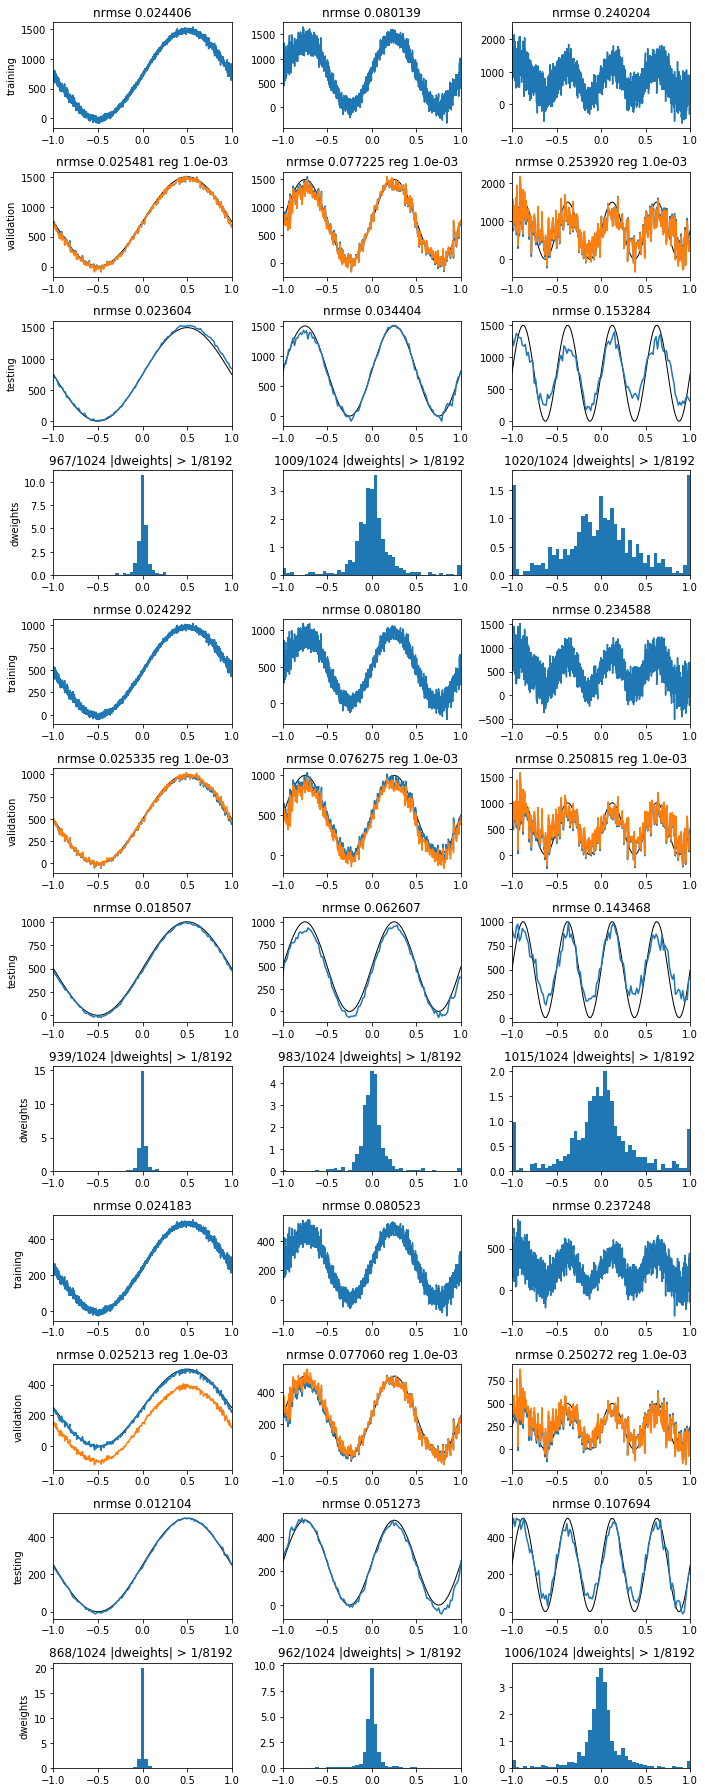

In [14]:
def check_plot_fits(exp_data):
    t_spike_rates = exp_data.training_spike_rates
    v_spike_rates = exp_data.validation_spike_rates
    
    t_input = exp_data.training_input_rates/exp_data.fmax_in
    v_input = exp_data.validation_input_rates/exp_data.fmax_in
    tst_input = exp_data.test_input_rates/exp_data.fmax_in
    
    exp_data.t_nrmse = np.zeros((len(exp_data.fmax_outs), len(exp_data.fcn_fs)))
    exp_data.v_nrmse = np.zeros_like(exp_data.t_nrmse)
    exp_data.vq_nrmse = np.zeros_like(exp_data.t_nrmse)
    exp_data.tst_nrmse = np.zeros_like(exp_data.t_nrmse)
    
    stim0_idx = np.argmin(np.abs(exp_data.training_input_rates)) # omit neurons that don't fire at 0
    spike_rates0 = exp_data.training_spike_rates[stim0_idx]
    nz_nrn0_idx = spike_rates0 > 0.
    
    hist_bins = np.linspace(-1, 1, 50)
    
    q_levels = 64
    q_res = 1/q_levels
    q_bins = np.hstack((-np.arange(q_levels+1)[::-1], np.arange(q_levels+1)[1:]))*q_res
    nrows = 4*len(exp_data.fmax_outs)
    ncols = len(exp_data.fcn_fs)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3+1,nrows*2+1))
    if ncols==1:
        axs = np.array([axs]).T.tolist()
    exp_data.tst_target = []
    exp_data.tst_observed = []
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.tst_target += [[]]
        exp_data.tst_observed += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            decoders = exp_data.decoders[idx0][idx1]
            q_idx = np.digitize(decoders-q_res/2, q_bins)
            q_decoders = q_bins[q_idx].reshape(decoders.shape)
            nz_decoders = decoders[np.logical_and(np.abs(decoders) >= 1/8192, nz_nrn0_idx.reshape(-1, 1))]
            
            t_target = exp_data.training_targets[idx0][idx1]
            v_target = fmax_out * FCN(v_input, fcn_f)
            tst_target = fmax_out * FCN(tst_input, fcn_f)
            
            t_fit = np.dot(t_spike_rates, decoders)
            v_fit = np.dot(v_spike_rates, decoders)
            vq_fit = np.dot(v_spike_rates, q_decoders)
            tst_observed = exp_data.test_output_rates[idx0][idx1]
            
            t_nrmse = get_nrmse(t_fit, t_target, fmax_out)
            v_nrmse = get_nrmse(v_fit, v_target, fmax_out)
            vq_nrmse = get_nrmse(vq_fit, v_target, fmax_out)
            tst_nrmse = get_nrmse(tst_observed, tst_target, fmax_out)
            axs[idx0*4+0][idx1].plot(t_input, t_target,'k', linewidth=1)
            axs[idx0*4+0][idx1].plot(t_input, t_fit)
            axs[idx0*4+1][idx1].plot(v_input, v_target,'k', linewidth=1)
            axs[idx0*4+1][idx1].plot(v_input, v_fit)
            axs[idx0*4+1][idx1].plot(v_input, vq_fit)
            axs[idx0*4+2][idx1].plot(tst_input, tst_target,'k', linewidth=1)
            axs[idx0*4+2][idx1].plot(tst_input, tst_observed)
            axs[idx0*4+3][idx1].hist(nz_decoders, bins=hist_bins, density=True)
            
            axs[idx0*4+0][idx1].set_xlim([-1, 1])
            axs[idx0*4+1][idx1].set_xlim([-1, 1])
            axs[idx0*4+2][idx1].set_xlim([-1, 1])
            axs[idx0*4+3][idx1].set_xlim([-1, 1])
            axs[idx0*4+0][idx1].set_title("nrmse {:.6f}".format(t_nrmse))
            axs[idx0*4+1][idx1].set_title("nrmse {:.6f} reg {:.1e}".format(v_nrmse, exp_data.reg[idx0, idx1]))
            axs[idx0*4+2][idx1].set_title("nrmse {:.6f}".format(tst_nrmse))
            axs[idx0*4+3][idx1].set_title("{}/{:d} |dweights| > 1/8192 ".format(
                np.sum(np.abs(decoders)>=1/8192), NNEURON))
            
            exp_data.t_nrmse[idx0, idx1] = t_nrmse
            exp_data.v_nrmse[idx0, idx1] = v_nrmse
            exp_data.vq_nrmse[idx0, idx1] = vq_nrmse
            exp_data.tst_nrmse[idx0, idx1] = tst_nrmse
            
            exp_data.tst_target[-1] += [tst_target]
            exp_data.tst_observed[-1] += [tst_observed]
            
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        axs[4*idx0+0][0].set_ylabel("training")
        axs[4*idx0+1][0].set_ylabel("validation")
        axs[4*idx0+2][0].set_ylabel("testing")
        axs[4*idx0+3][0].set_ylabel("dweights")
    plt.tight_layout()
    fig.savefig(FIG_DIR + "train_validate_test" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
                "_fmax_in_" + str(FMAX_IN) +
                "_fcn_f_" + str(FCN_F) + "_fmax_out_" + str(FMAX_OUTS) + ".png")
    
#     fname_pre = (DATA_DIR + "fit_data_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
#                  "_fcn_f_" + str(FCN_F) + "_fmax_out_" + str(FMAX_OUTS) + "_")
#     fname_posts = ['tst_input', 'tst_target', 'tst_observed', 'tst_nrmse', 'decoders']
#     data_structs = [tst_input, exp_data.tst_target, exp_data.tst_observed, exp_data.decoders]
#     for fname_post, data_struct in zip(fname_posts, data_structs):
#         fname = fname_pre + fname_post + ".pck"
#         with open(fname, 'wb') as fhandle:
#             pickle.dump(data_struct, fhandle)

check_plot_fits(EXP_DATA)

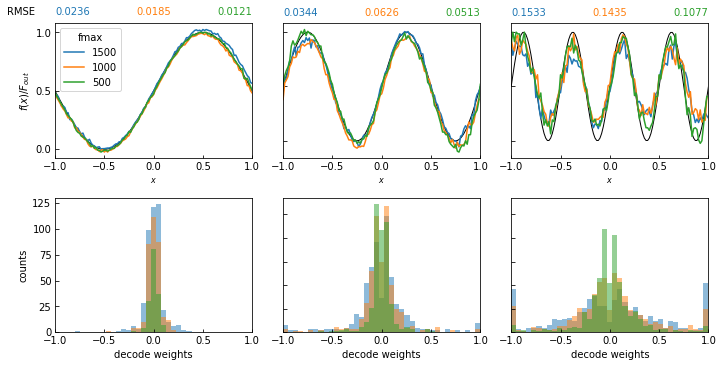

In [15]:
def plot_figure(exp_data):
    tst_input = exp_data.test_input_rates/exp_data.fmax_in
    
    stim0_idx = np.argmin(np.abs(exp_data.training_input_rates)) # omit neurons that don't fire at 0
    spike_rates0 = exp_data.training_spike_rates[stim0_idx]
    nz_nrn0_idx = spike_rates0 > 0.
    
    hist_bins = np.linspace(-1, 1, 40)
    
    nrows = 2
    ncols = len(exp_data.fcn_fs)
#     fig, axs = plt.subplots(nrows, ncols, figsize=(3.5, 2))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3+1,nrows*2+1))
    if ncols==1:
        axs = np.array([axs]).T.tolist()
    for idx1, fcn_f in enumerate(exp_data.fcn_fs):
        tst_target = FCN(tst_input, fcn_f)
        axs[0][idx1].plot(tst_input, tst_target, 'k', linewidth=1)
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            decoders = exp_data.decoders[idx0][idx1]
            nz_decoders = decoders[np.logical_and(np.abs(decoders) >= 1/64, nz_nrn0_idx.reshape(-1, 1))]
            axs[0][idx1].plot(tst_input, exp_data.test_output_rates[idx0][idx1]/fmax_out,
                              label="{:d}".format(fmax_out))
            axs[1][idx1].hist(nz_decoders, bins=hist_bins, alpha=0.5, label="{:d}".format(fmax_out))
    def set_axs_fmt(fig, axs, exp_data):
        ylim_mins = np.min(
            np.array([[axs[idx0][idx1].get_ylim()[0] for idx1 in range(len(exp_data.fcn_fs))]
                     for idx0 in range(2)]), axis=1)
        ylim_maxes = np.max(
            np.array([[axs[idx0][idx1].get_ylim()[1] for idx1 in range(len(exp_data.fcn_fs))]
                     for idx0 in range(2)]), axis=1)
        axs[0][0].tick_params(direction='in')
        axs[1][0].tick_params(direction='in')
        for idx0 in range(2):
            for idx1 in range(len(exp_data.fcn_fs))[1:]:
                axs[idx0][idx1].set_ylim(ylim_mins[idx0], ylim_maxes[idx0])
        for idx1 in range(len(exp_data.fcn_fs)):
            axs[0][idx1].set_yticks([0, 0.5, 1])
        for idx1 in range(len(exp_data.fcn_fs))[1:]:
            axs[0][idx1].set_yticklabels([])
            axs[1][idx1].set_yticklabels([])
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            ax_pos = axs[0][idx1].get_position()
            colors = [axs[0][idx1].get_lines()[idx0].get_color() for idx0 in range(1, len(exp_data.fmax_outs)+1)]
            ymax = axs[0][idx1].get_ylim()[1]
            if len(exp_data.fmax_outs) == 3:
                axs[0][idx1].text(-1, 1.05*ymax, "{:.4f}".format(
                    exp_data.tst_nrmse[0][idx1]), ha="left", va="bottom", color=colors[0])
                axs[0][idx1].text(0, 1.05*ymax, "{:.4f}".format(
                    exp_data.tst_nrmse[1][idx1]), ha="center", va="bottom", color=colors[1])
                axs[0][idx1].text(1, 1.05*ymax, "{:.4f}".format(
                    exp_data.tst_nrmse[2][idx1]), ha="right", va="bottom", color=colors[2])
            axs[0][idx1].set_xlabel(r"$x$", fontsize=8)
            axs[1][idx1].set_xlabel("decode weights")
            axs[0][idx1].tick_params(direction='in')
            axs[1][idx1].tick_params(direction='in')
            axs[0][idx1].set_xlim([-1, 1])
            axs[1][idx1].set_xlim([-1, 1])
        axs[0][0].legend(loc="upper left", title="fmax")
        axs[0][0].set_ylabel(r"$f(x)/F_{out}$")
        axs[1][0].set_ylabel("counts")
    set_axs_fmt(fig, axs, exp_data)
    plt.tight_layout()
    fig.text(0, 1.01, "RMSE", ha="left", va="top")
#     for fmt_str in ['.png']:
    for fmt_str in ['.png', '.svg']:
        fig.savefig(FIG_DIR + "test_decode_weights" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
                    "_fcn_f_" + str(FCN_F) + "_fmax_out_" + str(FMAX_OUTS) + fmt_str,
                   bbox_inches="tight")
            
plot_figure(EXP_DATA)

# Test Decoder Statistics

In [19]:
def est_poisson_snr(exp_data):
    idx_0 = np.argmin(np.abs(exp_data.training_input_rates))
    tuning_0 = np.mean(exp_data.training_spike_rates[idx_0-5:idx_0+5], axis=0)
    exp_data.snr_pred_poi = np.zeros((len(exp_data.fmax_outs), len(exp_data.fcn_fs)))
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            dweights = exp_data.decoders[idx0][idx1].flatten()
            mean_pred = np.sum(dweights * tuning_0)
            var_poi = np.sum(dweights**2 * np.abs(tuning_0)/(2*TAU_READOUT))
            exp_data.snr_pred_poi[idx0, idx1] = mean_pred/np.sqrt(var_poi)
    SNR_POI_FNAME = (DATA_DIR + "snr_plot_" +
        str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + "_poi_pred" ".pck")
    snr_data = exp_data.snr_pred_poi
    with open(SNR_POI_FNAME, 'wb') as fhandle:
        pickle.dump(snr_data, fhandle)
est_poisson_snr(EXP_DATA)

In [16]:
def enable_neurons(y, x):
    for y_idx, x_idx in zip(range(y), range(x)):
        hal.driver.EnableSomaXY(0, x_idx, y_idx)
    hal.flush()

def disable_neurons(y, x, disable_y, disable_x):
    for y_idx, x_idx in zip(range(y), range(x)):
        hal.driver.EnableSomaXY(0, x_idx, y_idx)
    print("disabling {:d} neurons".format(len(disable_y)))
    for y_idx, x_idx in zip(disable_y, disable_x):
        hal.driver.DisableSomaXY(0, x_idx, y_idx)
    hal.flush()

def run_raw_spikes_test(hal, net, run_control, test_time=1):
    """Run a single input test trial and collect the raw spikes"""
    test_time_ns = int(test_time*1E9)

    input_rates = np.zeros((2, 1))
    input_times = np.arange(2)*test_time_ns
    input_vals = {net.input:(input_times, input_rates)}
    
    _, spike_data = run_control.run_input_sweep(
        input_vals, get_raw_spikes=True, get_outputs=True)

    spikes, bin_times_ns = spike_data
    spikes = spikes[net.pool]
    bin_times = bin_times_ns * 1E-9
    bin_times -= bin_times[0]
    return spikes, bin_times

def run_decoders_raw_spikes(exp_data, net, hal, run_control):
    """Test the output decode spike statistics"""
    hal.set_time_resolution(TESTING_RAW_SPIKES_DOWNSTREAM_NS, TESTING_RAW_SPIKES_UPSTREAM_NS)
    exp_data.raw_spikes = []
    exp_data.raw_spikes_bin_times = []
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.raw_spikes += [[]]
        exp_data.raw_spikes_bin_times += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            print("----------------------------------------------")
            print("Collecting raw spike data for fcn_f {} fmax_out {}".format(fcn_f, fmax_out))
            dweights = np.zeros((2, Y*X))
            net.decoder_conn.reassign_weights(dweights)
            hal.remap_weights()
            ##### # kill the neurons that have decode weights that will be clipped
            threshold = 1/8192 # finest possible precision
            # threshold = find_threshold(exp_data.decoders[idx0][idx1]) # actual precision
            disable_y, disable_x = np.nonzero((np.abs(exp_data.decoders[idx0][idx1])<threshold).reshape((Y, X)))
            disable_neurons(Y, X, disable_y, disable_x)
            #######
            raw_spikes, raw_spikes_bin_times = run_raw_spikes_test(hal, net, run_control)
            enable_neurons(Y, X) # undo disabling of neurons
            print("checking raw spikes")
            decode = utils.check_bins(raw_spikes)
            exp_data.raw_spikes[-1] += [raw_spikes]
            exp_data.raw_spikes_bin_times[-1] += [raw_spikes_bin_times]
            # check decode spikes
# run_decoders_raw_spikes(EXP_DATA, NET, hal, run_control)

In [17]:
def analyze_decodes_raw_spikes(exp_data):
    exp_data.raw_snr = [] # snr of decode weights applied to raw spikes
    exp_data.filtered_decoded_raw_spikes = []
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.raw_snr += [[]]
        exp_data.filtered_decoded_raw_spikes += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            # raw spikes
            raw_spikes_bin_times = exp_data.raw_spikes_bin_times[idx0][idx1]
            raw_spikes = exp_data.raw_spikes[idx0][idx1]
            decoded_raw_spikes = np.dot(raw_spikes, exp_data.decoders[idx0][idx1])
            # process raw spikes
            dt_raw_spikes = raw_spikes_bin_times[1] - raw_spikes_bin_times[0]
            filtered_decoded_raw_spikes = lpf(decoded_raw_spikes, TAU_READOUT, dt_raw_spikes)
            
            idx = raw_spikes_bin_times>CLIP_TIME
            raw_mean = np.mean(filtered_decoded_raw_spikes[idx])
            raw_var = np.var(filtered_decoded_raw_spikes[idx])
            raw_snr = raw_mean/np.sqrt(raw_var)
            info_str = "fmax_out {:4d} fcn_f {:.1f} expected mean {:4.0f} ".format(fmax_out, fcn_f, fmax_out/2)
            info_str += "mean {:6.0f} var {:8.0f} snr {:5.2f}".format(raw_mean, raw_var, raw_snr)
            print(info_str)
            
            exp_data.raw_snr[-1] += [raw_snr]
            exp_data.filtered_decoded_raw_spikes[-1] += [filtered_decoded_raw_spikes]
# analyze_decodes_raw_spikes(EXP_DATA)

In [18]:
#  deliver an input of 0
def run_test(hal, net, run_control, test_time=1):
    """Run a single input test trial"""
    test_time_ns = int(test_time*1E9)

    input_rates = np.zeros((2, 1))
    input_times = np.arange(2)*test_time_ns

    input_vals = {net.input:(input_times, input_rates)}
    output_data, _ = run_control.run_input_sweep(
        input_vals, get_raw_spikes=False, get_outputs=True)

    outputs, bin_times_ns = output_data
    outputs = outputs[net.output]
    decode = outputs[:, 0]
    spikes = outputs[:, 1]
    
    bin_times = bin_times_ns * 1E-9
    bin_times -= bin_times[0]
    return decode, spikes, bin_times

def run_decoders(exp_data, net, hal, run_control):
    """Test the output decode spike statistics"""
    hal.set_time_resolution(TESTING_DOWNSTREAM_NS, TESTING_UPSTREAM_NS)
    exp_data.decodes = []
    exp_data.spikes = []
    exp_data.bin_times = []
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.decodes += [[]]
        exp_data.spikes += [[]]
        exp_data.bin_times += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            print("----------------------------------------------")
            print("Collecting decode and total spike data for fcn_f {} fmax_out {}".format(fcn_f, fmax_out))
            decoders = exp_data.decoders[idx0][idx1].flatten()
            dweights = np.ones((2, Y*X))
            dweights[0] = decoders
            dweights[1][decoders<1/8192] = 0
            net.decoder_conn.reassign_weights(dweights)
            hal.remap_weights()
            decode, spikes, bin_times = run_test(hal, net, run_control, test_time=10)
            print("checking decoded-weighted spikes")
            decode = utils.check_bins(decode)
            print("checking summed spikes")
            spikes = utils.check_bins(spikes)
            exp_data.decodes[-1] += [decode]
            exp_data.spikes[-1] += [spikes]
            exp_data.bin_times[-1] += [bin_times]
run_decoders(EXP_DATA, NET, HAL, RUN_CONTROL)

----------------------------------------------
checking decoded-weighted spikes
Collected 7495 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 92505
                   1 : 7495
Sum(bins) = 7495
checking summed spikes
Collected 99993 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 7
                   1 : 95
                   2 : 410
                   3 : 1281
                   4 : 3150
                   5 : 5701
                   6 : 8931
                   7 : 11775
                   8 : 13532
                   9 : 13550
                  10 : 12255
                  11 : 9864
                  12 : 7367
                  13 : 4998
                  14 : 3217
                  15 : 1852
                  16 : 1055
                  17 : 521
                  18 : 256
                  19 : 102
                  20 : 49
                  21 : 25
                  22 : 3
                  23 : 4
Sum(bins) = 903276
------------------------

checking decoded-weighted spikes
Collected 4700 non-zero bins.
Bin stats (bin value : N bins)
                  -2 : 11
                  -1 : 2876
                   0 : 92413
                   1 : 4674
                   2 : 26
Sum(bins) = 1828
checking summed spikes
Collected 99898 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 102
                   1 : 677
                   2 : 2328
                   3 : 5585
                   4 : 9744
                   5 : 13553
                   6 : 15702
                   7 : 14907
                   8 : 12931
                   9 : 9738
                  10 : 6592
                  11 : 3950
                  12 : 2175
                  13 : 1101
                  14 : 525
                  15 : 237
                  16 : 90
                  17 : 46
                  18 : 14
                  19 : 3
Sum(bins) = 681699


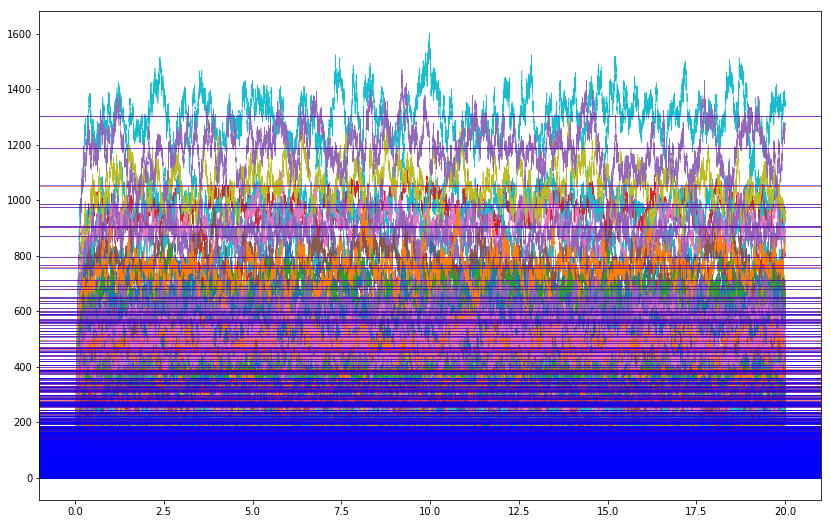

In [19]:
def collect_tuning_0(exp_data, hal, net, run_control):
    spikes, bin_times = run_raw_spikes_test(hal, net, run_control, test_time=20)
    dt = bin_times[1] - bin_times[0]
    idx = bin_times > CLIP_TIME
    clip_bins = bin_times[idx]
    mean_spikes = np.sum(spikes[idx], axis=0)/(clip_bins[-1] - clip_bins[0])
    filtered_spikes = lpf(spikes, TAU_READOUT, dt)
    mean_filtered_spikes = np.mean(filtered_spikes[idx], axis=0)
    
    plt.figure(figsize=(14, 9))
    plt.plot(bin_times, filtered_spikes, linewidth=0.5)
    for ms in mean_spikes:
        plt.axhline(ms, color='r', linewidth=1, alpha=0.2)
    for ms in mean_filtered_spikes:
        plt.axhline(ms, color='b', linewidth=1, alpha=0.2)
    exp_data.tuning_0 = mean_spikes
collect_tuning_0(EXP_DATA, HAL, NET, RUN_CONTROL)

In [64]:
TAU_READOUT = 0.1
def var_u(lam, tau):
    lamtau = lam*tau
    var = np.zeros_like(lam)
    idx = lam > 0
    var[idx] = lam[idx]**2*(1./(2.*lamtau[idx])*(1+np.exp(-1/(lamtau[idx])))/(1-np.exp(-1/(lamtau[idx])))-1)
    return var

def analyze_decodes(exp_data):
    exp_data.fin = np.zeros((len(exp_data.fmax_outs), len(exp_data.fcn_fs)))
    exp_data.fout = np.zeros((len(exp_data.fmax_outs), len(exp_data.fcn_fs)))
    exp_data.mean = np.zeros((len(exp_data.fmax_outs), len(exp_data.fcn_fs)))
    exp_data.snr = np.zeros((len(exp_data.fmax_outs), len(exp_data.fcn_fs)))
    exp_data.snr_pred_poi = np.zeros((len(exp_data.fmax_outs), len(exp_data.fcn_fs)))
    exp_data.snr_pred_per = np.zeros((len(exp_data.fmax_outs), len(exp_data.fcn_fs)))
    exp_data.filtered_decode = []
    exp_data.filtered_spikes = []
    
    idx_0 = np.argmin(np.abs(exp_data.training_input_rates))
    tuning_0 = np.mean(exp_data.training_spike_rates[idx_0-5:idx_0+5], axis=0)
#     tuning_0 = exp_data.tuning_0
    
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.filtered_decode += [[]]
        exp_data.filtered_spikes += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            # decode data and total fin spikes
            bin_times = exp_data.bin_times[idx0][idx1]
            decode = exp_data.decodes[idx0][idx1]
            spikes = exp_data.spikes[idx0][idx1]
            # filter decode
            dt = bin_times[1] - bin_times[0]
            filtered_spikes = lpf(spikes, TAU_READOUT, dt)
            filtered_decode = lpf(decode, TAU_READOUT, dt)
            
            idx = bin_times>CLIP_TIME
            fin = np.sum(spikes[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
            fout = np.sum(decode[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
            mean = np.mean(filtered_decode[idx])
            var = np.var(filtered_decode[idx])
            snr = mean/np.sqrt(var)
            info_str = "fmax_out {:4d} fcn_f {:.1f} expected mean {:4.0f} ".format(fmax_out, fcn_f, fmax_out/2)
            info_str += "fin {: 6.0f} mean {:6.0f} var {:8.0f} snr {:5.2f}".format(fin, mean, var, snr)
            print(info_str)
            
            dweights = exp_data.decoders[idx0][idx1].flatten()
            mean_pred = np.sum(dweights * tuning_0)
            var_poi = np.sum(dweights**2 * np.abs(tuning_0)/(2*TAU_READOUT))
#             var_per = np.sum(dweights**2)/(12*TAU_READOUT**2)
            var_per = np.sum(dweights**2 * var_u(tuning_0, TAU_READOUT))
#             var_per = var_u(mean_pred, TAU_READOUT)
            print(mean_pred)
            print(var_per)
            
            exp_data.snr_pred_poi[idx0, idx1] = mean_pred/np.sqrt(var_poi)
            exp_data.snr_pred_per[idx0, idx1] = np.clip(
                mean_pred/np.sqrt(var_per), None, utils.get_snr_periodic(mean_pred*TAU_READOUT))
            
            exp_data.fin[idx0, idx1] = fin
            exp_data.fout[idx0, idx1] = fout
            exp_data.mean[idx0, idx1] = mean
            exp_data.snr[idx0, idx1] = snr
            exp_data.filtered_spikes[-1] += [filtered_spikes]
            exp_data.filtered_decode[-1] += [filtered_decode]

analyze_decodes(EXP_DATA)

fmax_out 1500 fcn_f 1.0 expected mean  750 fin  90327 mean    749 var       86 snr 80.79
753.96603206712
41.543474651769316
fmax_out 1500 fcn_f 2.0 expected mean  750 fin  78193 mean    751 var      717 snr 28.04
756.6276080599223
577.1695759538038
fmax_out 1500 fcn_f 4.0 expected mean  750 fin  68203 mean    662 var     3335 snr 11.47
772.5913770558268
2047.5701025041067
fmax_out 1000 fcn_f 1.0 expected mean  500 fin  89760 mean    501 var       55 snr 67.45
502.4445154911323
17.036475949988088
fmax_out 1000 fcn_f 2.0 expected mean  500 fin  77556 mean    533 var      363 snr 27.98
505.91615989638507
283.4775163839311
fmax_out 1000 fcn_f 4.0 expected mean  500 fin  66027 mean    481 var     2244 snr 10.15
507.57982355002673
1357.827025978734
fmax_out  500 fcn_f 1.0 expected mean  250 fin  87518 mean    255 var       16 snr 64.14
251.00057252653573
3.5830403763720526
fmax_out  500 fcn_f 2.0 expected mean  250 fin  76454 mean    275 var       94 snr 28.38
253.23658201729702
65.898786792

In [65]:
def plot_decode_output(exp_data, tau):
    # plot filtered decodes and spikes out
    fin = np.array(exp_data.fin)
    fout = np.array(exp_data.fout)
    
    nrows = len(exp_data.fmax_outs)
    ncols = len(exp_data.fcn_fs)
    fig_filt, axs_filt = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,
                                      figsize=(ncols*3+1, nrows*2+1))
    fig_filt_fout, axs_filt_fout = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,
                                      figsize=(ncols*3+1, nrows*2+1))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][2:]
    len_c = len(colors)
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            
            # decode data and total fin spikes
            bin_times = exp_data.bin_times[idx0][idx1]
            filtered_decode = exp_data.filtered_decode[idx0][idx1]
            filtered_spikes = exp_data.filtered_spikes[idx0][idx1]
            # raw spikes
            
            fin = exp_data.fin[idx0][idx1]
            fout = exp_data.fout[idx0][idx1]
            mean = exp_data.mean[idx0][idx1]

            ax = axs_filt[idx0][idx1]
            ax.axhline(fin, color="k", alpha=0.5)
            ax.axhline(fout, color="k", alpha=0.5)
            ax.plot(bin_times, filtered_spikes)
            ax.plot(bin_times, filtered_decode)
            
            ax = axs_filt_fout[idx0][idx1]
            ax.axhline(fout, color="k", alpha=0.5)
            ax.plot(bin_times, filtered_decode)
            # raw spikes
#             raw_spikes_bin_times = exp_data.raw_spikes_bin_times[idx0][idx1]
#             filtered_decoded_raw_spikes = exp_data.filtered_decoded_raw_spikes[idx0][idx1]
#             ax.plot(raw_spikes_bin_times, filtered_decoded_raw_spikes)
#             ax.plot(raw_spikes_bin_times, filtered_decoded_raw_spikes)
    for idx1, fcn_f in enumerate(exp_data.fcn_fs):
        axs_filt[0][idx1].set_title("fmax*(sin({:.1f}*pi*x)/2+0.5)".format(fcn_f))
        axs_filt[-1][idx1].set_xlabel("Time (s)")
    plt.tight_layout()
    fig_filt.savefig(FIG_DIR + "accumulator_filt" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + ".png")
# plot_decode_output(EXP_DATA, TAU_READOUT)

116.97697098617282
31.494191854909957
17.07381088976659
121.73016977684489
30.0482540347164
13.77469927211799
86.95029894563537
31.195197067346783
10.161878601188882


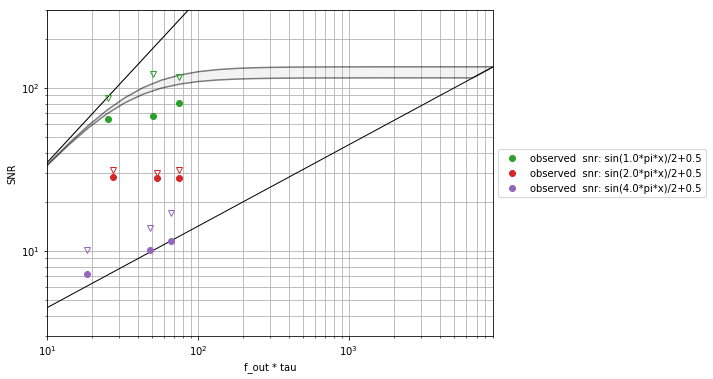

In [68]:
def plot_decode_stats(exp_data, tau):
    # plot on gamma plot
    fin = np.array(exp_data.fin)
    fout = np.array(exp_data.fout)
    ylim_min = 10**(int(np.log10(np.min(exp_data.snr))))
    xlim_min = 10**(int(np.log10(fout.min())))*tau
    fend = np.array([xlim_min/tau, fin.max()])
    fout_plot = np.logspace(np.log10(fend[0]), np.log10(fend[1]))
    
    fig_snr, ax_snr = plt.subplots(figsize=(8, 6))

    snr_per = utils.get_snr_periodic(fout_plot*tau)
    snr_per_high_lt_appx = np.sqrt(12)*fend*tau
    snr_poi = np.sqrt(2*fout_plot*tau)
    ax_snr.loglog(fout_plot*tau, snr_per, "k", linewidth=1)
    ax_snr.loglog(fend*tau, snr_per_high_lt_appx, "k", linewidth=1, alpha=0.2)
    ax_snr.loglog(fout_plot*tau, snr_poi, "k", linewidth=1)
    
    k_max = np.max(fin/fout)
    
    k_plt = np.logspace(0, int(np.log2(k_max))+4, 100)
    fin_max = np.max(fin)
    fin_min = np.min(fin)
    fin_max_min = fin_max/fin_min
    
    fout_max = fin_max / k_plt
    fout_min = fin_min / k_plt
    
    snr_gamma_max = utils.get_snr_gamma_approx(fout_max*tau, k_plt)
    snr_gamma_min = utils.get_snr_gamma_approx(fout_min*tau, k_plt)

    len_plt = len(fout_min) + 1
    fout_plt = np.array([fout_max[0]] + list(fout_min))
    
    snr_gamma_min_plt = np.zeros(len_plt)
    snr_gamma_min_plt[0] = snr_gamma_max[0]
    snr_gamma_min_plt[1:] = snr_gamma_min
    
    k_max_plt = k_plt * fin_max / fin_min
    snr_gamma_max_plt = np.zeros(len_plt)
    snr_gamma_max_plt[0] = snr_gamma_max[0]
    snr_gamma_max_plt[1:] = utils.get_snr_gamma_approx(fout_plt[1:]*tau, k_max_plt)
    
    ylim_max = 10**(int(np.log10(np.max(snr_gamma_max_plt)))+1)
    ylim_min = 10**(int(np.log10(np.min(exp_data.snr))))
    
    fill_color = plt.get_cmap("Greys")(.1)
    ax_snr.fill_between(fout_plt*tau, snr_gamma_max_plt, snr_gamma_min_plt, facecolor=fill_color)
    ax_snr.loglog(fout_plt*tau, snr_gamma_max_plt, '-k', alpha=0.5)
    ax_snr.loglog(fout_plt*tau, snr_gamma_min_plt, '-k', alpha=0.5)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][2:]
    len_c = len(colors)
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            fin = exp_data.fin[idx0, idx1]
            fout = exp_data.fout[idx0, idx1]
            mean = exp_data.mean[idx0, idx1]
            snr = exp_data.snr[idx0, idx1]
            snr_pred_poi = exp_data.snr_pred_poi[idx0, idx1]
            snr_pred_per = exp_data.snr_pred_per[idx0, idx1]

            k_eff = fin/fout
            snr_th = utils.get_snr_gamma_approx(fout*tau, k_eff)
            if idx0 == 0:
                label_t = "predicted snr: sin({:.1f}*pi*x)/2+0.5".format(fcn_f)
                label_acc_in = "est acc in snr: sin({:.1f}*pi*x)/2+0.5".format(fcn_f)
                label_o = "observed  snr: sin({:.1f}*pi*x)/2+0.5".format(fcn_f)
            else:
                label_o = None
                label_acc_in = None
                label_t = None
#             ax_snr.loglog(fout*tau, snr_th, 'o', color=colors[idx1%len_c], fillstyle='none', label=label_t)
#             ax_snr.loglog(fout*tau, snr_pred_poi, '^', color=colors[idx1%len_c], fillstyle='none')
            ax_snr.loglog(fout*tau, snr_pred_per, 'v', color=colors[idx1%len_c], fillstyle='none')
            print(snr_pred_per)
            ax_snr.loglog(fout*tau, snr, 'o', color=colors[idx1%len_c], label=label_o)
    lgd = ax_snr.legend(bbox_to_anchor=(1, 0.5), loc="center left")
    
    ax_snr.set_xlim((xlim_min, fin_max*tau))
    ax_snr.set_ylim((3, 300))
    ax_snr.set_xlabel("f_out * tau")
    ax_snr.set_ylabel("SNR")
    ax_snr.grid(which="both")
    fig_snr.savefig(FIG_DIR + "snr" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + ".png",
                    bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    SNR_FNAME = (DATA_DIR + "snr_plot_" +
        str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + ".pck")

    snr_data = (fend, fout_plot, fout_plt,
                snr_per, snr_poi, snr_gamma_min_plt, snr_gamma_max_plt,
                exp_data.fmax_outs, exp_data.fcn_fs,
                exp_data.fout, exp_data.snr, exp_data.snr_pred_per,
                (ax_snr.get_xlim(), ax_snr.get_ylim())
               )
    with open(SNR_FNAME, 'wb') as fhandle:
        pickle.dump(snr_data, fhandle)
plot_decode_stats(EXP_DATA, TAU_READOUT)